# Compare barometric pressure recorded by analog barometers and vibrating wire sensors
Here we use the 4-hourly summary data.
* Analog barometers are temperature-corrected, so can be considered a direct measure of true barometric pressure. However, the still need correcting to a height of 0 feet.
* Vibrating wire sensors need to be corrected with the corresponding temperature data, and height corrected to 0 feet.

## 1. Set up and Load transducers metadata

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import header
paths = header.setup_environment()
import platform
if platform.system()=='Darwin':
    INPUTDIR = '/Users/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/MERGED'
else:
    INPUTDIR = os.path.join(paths['new_data'], '03_merge_inventories')
import libWellData as LLE
transducersDF = LLE.get_transducers_dataframe(paths)
display(transducersDF)

/var/folders/4q/5426zn1d72vgcb6h658n_8800000gn/T/ipykernel_57137/3050272850.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Darwin


,serial,Fs,sensor,shielding,range_kPa_low,range_kPa_high,media,type,model,set_depth_ft,id,well,tmean,dig0,gf,tt,tt0,tf,bp,bp0
0,AirPressureShallow,100,barometer,none,100,100,air,pressure,Keller 0507.01401.051311.07,3.81,6S.02374.88.HDH,shallow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1226420,100,vibrating_wire,none,70,170,air,level,Geokon 4500AL,4.46,6S.12264.20.HDD,shallow,30.68,9751.0,-0.006458,21.6,21.3,-0.008795,14.504,14.298
2,1226423,20,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-5.83,6S.12264.23.BDD,shallow,28.40,9605.0,-0.006347,21.6,22.2,-0.004197,14.504,14.298
3,1226419,100,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-6.71,6S.12264.19.HDD,shallow,27.57,10040.0,-0.006441,21.6,21.1,-0.010870,14.504,14.298
4,1226421,100,vibrating_wire,none,70,170,water,level,Geokon 4500AL,-7.71,6S.12264.21.HDD,shallow,27.60,9787.0,-0.006724,21.6,21.3,-0.001145,14.504,14.298
5,AirPressureDeep,100,barometer,none,100,100,air,pressure,Keller 0507.01401.051311.07,3.86,6I.0XXXX.XX.HDH,intermediate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1226429,100,vibrating_wire,none,70,170,air,level,Geokon 4500AL,4.11,6I.12264.29.HDD,intermediate,30.60,9800.0,-0.006428,22.6,21.6,-0.002384,14.367,14.298
7,2151692,20,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-9.14,6I.21516.92.BDD,intermediate,25.88,9459.0,-0.008038,22.8,21.8,0.007666,14.296,14.388
8,2151691,100,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-18.31,6I.21516.91.HDD,intermediate,25.70,9414.0,-0.008142,22.8,21.5,0.008742,14.296,14.388
9,2149882,100,vibrating_wire,none,70,170,water,level,Geokon 4500AL,-19.14,6I.21498.82.HDD,intermediate,25.96,9734.0,-0.008075,20.7,21.3,0.000675,14.602,14.389


# 2. Subset the summary of all files dataframe by Baro, 20 Hz, and 100 Hz subdirectories
Display the columns of each, after dropping empty columns.
* Baro only contains data columns for AirPressureShallow and AirPressureDeep.
* 20 Hz contains data columns for 1226423 and 2151692, plus corresponding temperature and stdev data
* 100 Hz contains data columns for '1226421', '1226419', '1226420', '2149882','2151691', and '1226429', plus corresponding temperature and stdev data

We plot:
- the barometric data
- the 100 Hz temperature data

Since none of these needs to be corrected (although later we will adjust barometric data to a height of 0 feet)

In [2]:
summarydf = LLE.load_summary_csv(os.path.join(INPUTDIR, 'all2.csv'), split=True, remerge=True)

In [3]:
#display(summary_dataframes['100hz'])
display(summarydf)
print(summarydf.columns)

,1226421,1226419,1226420,2149882,2151691,1226429,1226421_temp,1226419_temp,1226420_temp,2149882_temp,...,uploaddate,subdir,basename,1226423_temp,2151692_temp,1226423_std,2151692_std,1226423,2151692,datetime
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20220826.0,20hz,20hz_Sensors_20Hz_20220721134750_000.csv,NaN,NaN,NaN,NaN,22819.189453,15339.369141,2022-07-21 13:47:50.000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20220826.0,20hz,20hz_Sensors_1Sec_20220721134750_000.csv,27.96347,25.815674,0.036595,0.027189,9078.993164,8428.339844,2022-07-21 13:47:50.000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,9167.110352,9489.996094,9703.25293,8627.779297,8358.027344,9770.319336,NaN,NaN,NaN,NaN,...,20220826.0,20hz,20hz_Sensors_20Hz_20220721160000_001.csv,NaN,NaN,NaN,NaN,9082.031250,8430.769531,2022-07-21 16:00:00.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,9143.607000,9463.829000,9707.10000,8611.594000,8341.694000,9767.984000,NaN,NaN,NaN,NaN,...,20221202.0,20hz,20hz_Sensors_20Hz_20221201120000_119.csv,NaN,NaN,NaN,NaN,9055.340820,8414.737305,2022-12-01 12:00:00.050
1081,9148.351000,9468.346000,9707.48900,8614.964000,8345.216000,9769.956000,NaN,NaN,NaN,NaN,...,20221202.0,20hz,20hz_Sensors_20Hz_20221201160000_120.csv,NaN,NaN,NaN,NaN,9060.303711,8418.320312,2022-12-01 16:00:00.050
1082,9144.639000,9464.844000,9706.25800,8612.217000,8341.727000,9767.146000,NaN,NaN,NaN,NaN,...,20221202.0,20hz,20hz_Sensors_20Hz_20221201200000_121.csv,NaN,NaN,NaN,NaN,9056.477539,8415.290039,2022-12-01 20:00:00.050
1083,9143.237000,9463.555000,9705.29800,8611.196000,8340.690000,9767.320000,NaN,NaN,NaN,NaN,...,20221202.0,20hz,20hz_Sensors_20Hz_20221202000000_122.csv,NaN,NaN,NaN,NaN,9055.333984,8414.057617,2022-12-02 00:00:00.050


Index(['1226421', '1226419', '1226420', '2149882', '2151691', '1226429',
       '1226421_temp', '1226419_temp', '1226420_temp', '2149882_temp',
       '2151691_temp', '1226429_temp', '1226421_std', '1226419_std',
       '1226420_std', '2149882_std', '2151691_std', '1226429_std',
       'nearestminute', 'AirPressureShallow', 'AirPressureDeep', 'uploaddate',
       'subdir', 'basename', '1226423_temp', '2151692_temp', '1226423_std',
       '2151692_std', '1226423', '2151692', 'datetime'],
      dtype='object')


## 3. Examine thermometer data 
For each vibrating wire pressure transducer, there is a corresponding thermal record
Find these columns and rename them to match the transducer serial number + "_temp"

1226421
{'serial': '1226421', 'Fs': 100, 'sensor': 'vibrating_wire', 'shielding': 'none', 'range_kPa_low': 70, 'range_kPa_high': 170, 'media': 'water', 'type': 'level', 'model': 'Geokon 4500AL', 'set_depth_ft': -7.71, 'id': '6S.12264.21.HDD', 'well': 'shallow', 'tmean': 27.6, 'dig0': 9787.0, 'gf': -0.006724, 'tt': 21.6, 'tt0': 21.3, 'tf': -0.001145, 'bp': 14.504, 'bp0': 14.298}
1226419
{'serial': '1226419', 'Fs': 100, 'sensor': 'vibrating_wire', 'shielding': 'foam', 'range_kPa_low': 70, 'range_kPa_high': 170, 'media': 'water', 'type': 'level', 'model': 'Geokon 4500AL', 'set_depth_ft': -6.71, 'id': '6S.12264.19.HDD', 'well': 'shallow', 'tmean': 27.57, 'dig0': 10040.0, 'gf': -0.006441, 'tt': 21.6, 'tt0': 21.1, 'tf': -0.01087, 'bp': 14.504, 'bp0': 14.298}
1226420
{'serial': '1226420', 'Fs': 100, 'sensor': 'vibrating_wire', 'shielding': 'none', 'range_kPa_low': 70, 'range_kPa_high': 170, 'media': 'air', 'type': 'level', 'model': 'Geokon 4500AL', 'set_depth_ft': 4.46, 'id': '6S.12264.20.HDD

1226421_temp    27.599284
1226419_temp    27.567062
1226420_temp    30.678610
2149882_temp    25.962010
2151691_temp    25.696426
1226429_temp    30.602692
1226423_temp    28.288307
2151692_temp    25.859416
dtype: float64

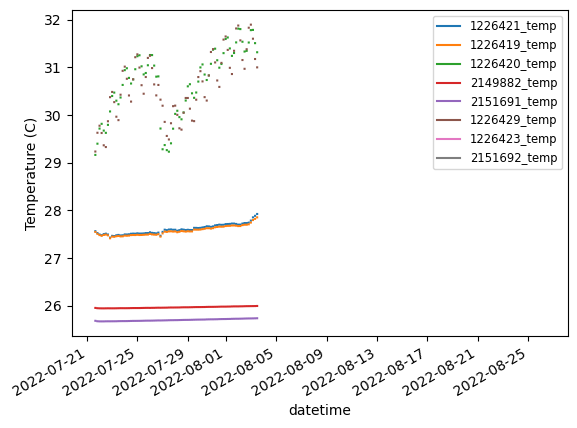

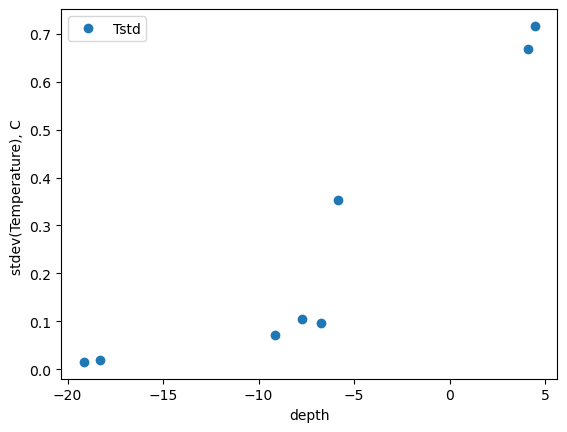

In [4]:
# subset to all rows that have a 'Therm(6)' column
#df100hz_thermal = summary_dataframes['100hz'].copy().dropna(subset=['Therm(6)'])
#df100hz_thermal = summarydf.copy().dropna(subset=['_temp'])
#df20hz_thermal = all_dataframes['20hz'].copy().dropna(subset=['Therm(2)'])
lod = []
for col in summarydf:
    if isinstance(col,str) and (col[0:2]=='12' or col[0:2]=='21'):
        if col.endswith('_temp') or col.endswith('_std'):
            continue
        print(col)
        this_transducer = LLE.get_transducer_metadata(col, transducersDF)
        print(this_transducer)
        depth = this_transducer['set_depth_ft']
        tempcol = col+'_temp'
        lod.append({'depth':depth, 'Tstd':summarydf[tempcol].std()})
thermal_columns = [item for item in summarydf.columns if item.endswith('_temp')]
summarydf.plot(x='datetime', y=thermal_columns, kind='line', ylabel='Temperature (C)').legend(bbox_to_anchor=(1.0,1.0), fontsize='small')
dftemp = pd.DataFrame(lod)
dftemp.plot(x='depth', y='Tstd', style='o', ylabel='stdev(Temperature), C ')
display(summarydf[thermal_columns].mean())


In [ ]:

# subset to all rows that have a 'Therm(6)' column
df20hz_thermal = all_dataframes['20hz'].copy().dropna(subset=['Therm(2)'])
count = 0 
lod = []
for col in df20hz_thermal:
    if isinstance(col,str) and (col[0:2]=='12' or col[0:2]=='21'):
        count += 1
        oldcol = f'Therm({count})'
        newcol = f'{col}_temp'
        print(oldcol,'->',newcol)
        df20hz_thermal.rename(columns={oldcol:newcol}, inplace=True)
        this_transducer = LLE.get_transducer_metadata(col, transducersDF)
        depth = this_transducer['set_depth_ft']
        lod.append({'depth':depth, 'Tstd':df20hz_thermal[newcol].std()})
thermal_columns = [item for item in df20hz_thermal.columns if item.endswith('_temp')]
df20hz_thermal.plot(x='datetime', y=thermal_columns, kind='line', ylabel='Temperature (C)').legend(bbox_to_anchor=(1.0,1.0), fontsize='small')
dftemp = pd.DataFrame(lod)
dftemp.plot(x='depth', y='Tstd', style='o', ylabel='stdev(Temperature), C ')
display(df20hz_thermal[thermal_columns].mean())

## 4. Plot raw barometric data


<Axes: xlabel='datetime'>

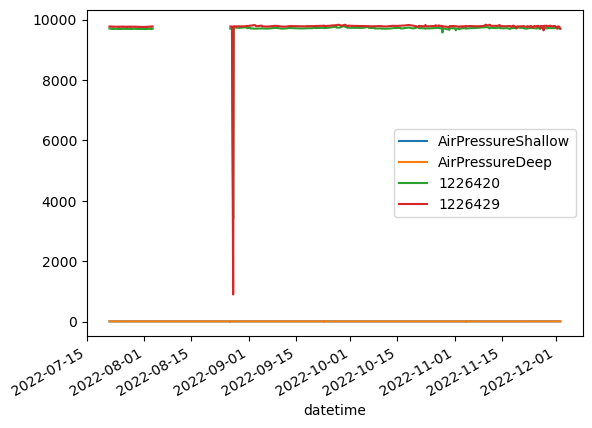

In [5]:
#all_dataframes['baro'].plot(x='datetime', y=['AirPressureShallow', 'AirPressureDeep'], kind='line')
#all_dataframes['100hz'].plot(x='datetime', y=['1226420', '1226429'], kind='line')
aircolumns = ['AirPressureShallow', 'AirPressureDeep', '1226420', '1226429']
summarydf.plot(x='datetime', y=aircolumns, kind='line')


## 5. Correct all barometers and vibrating wire sensor data
- barometers are corrected for height only
- vibrating wire sensors in air are corrected for height also
- all vibrating wire sensors are corrected for sensitivity, and temperature
- vibrating wire sensors in water are corrected for barometric pressure too, from vibrating wire sensor in air

<Axes: xlabel='datetime'>

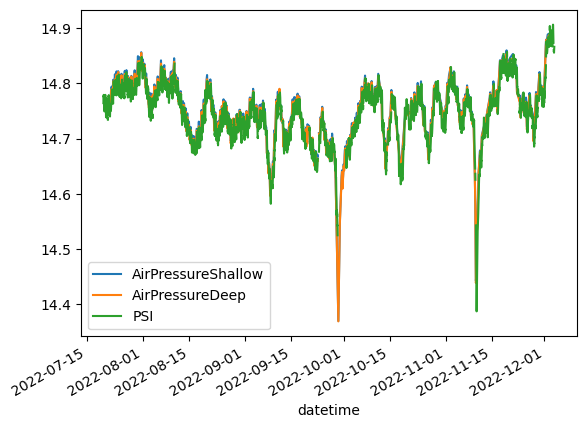

In [13]:
'''
dfbaro_elevationRemoved_PSI = LLE.correctBarometricData(all_dataframes['baro'], aircolumns[:2], transducersDF, temperatureCorrect=False, heightCorrect=True)  
dfbaro_elevationRemoved_PSI.plot(x='datetime', y=['AirPressureShallow', 'AirPressureDeep'], kind='line')
df100hz_elevationRemoved_aircolumnonly = LLE.correctBarometricData(df100hz_thermal, aircolumns[2:], transducersDF, temperatureCorrect=True, heightCorrect=True)
df100hz_elevationRemoved_PSI = LLE.rawdf2psidf(df100hz_elevationRemoved_aircolumnonly, transducersDF, temperatureCorrect=True, airpressureColumn='1226429', depthCorrect=False)
df100hz_elevationRemoved_PSI.plot(x='datetime', y=aircolumns[2:], kind='line')
'''
correcteddf = LLE.correctBarometricData(summarydf, aircolumns[:2], transducersDF, temperatureCorrect=False, heightCorrect=True)  
ax=correcteddf.plot(x='datetime', y=['AirPressureShallow', 'AirPressureDeep'], kind='line')
#display(correcteddf[aircolumns[2:]])
correcteddf = LLE.correctBarometricData(correcteddf, aircolumns[2:], transducersDF, temperatureCorrect=True, heightCorrect=True)
#correcteddf = LLE.rawdf2psidf(correcteddf, transducersDF, temperatureCorrect=True, airpressureColumn='1226429', depthCorrect=False)
#correcteddf.plot(x='datetime', y=aircolumns[2:], kind='line')
#display(correcteddf[aircolumns[2:]])

dfnasa = pd.read_csv('Barometric Pressure.csv')
dfnasa['datetime']=pd.to_datetime(dfnasa['datetime'])
dfnasa.plot(ax=ax, x='datetime', y='PSI')

## 6. Merge the dataframes after rounding timestamps to nearest minute
All time series from the all2.csv are 4-hourly since we have only 1 file per 4 hours. So we can round to the nearest minute to align times that are generally within 1-s

Drop columns we do not need

In [ ]:
LLE.round_datetime(df100hz_elevationRemoved_PSI, freq='min' )
LLE.round_datetime(dfbaro_elevationRemoved_PSI, freq='min')
dfmerged1 = LLE.merge_and_drop(df100hz_elevationRemoved_PSI, dfbaro_elevationRemoved_PSI, on='nearestminute')
display(dfmerged1)
dfmerged1.plot(x='nearestminute', y=aircolumns, kind='line')

## 7. Correlate the air pressure columns - and compare their means too


In [ ]:
xcorrdf1, dcshiftdf1 = LLE.xcorr_columns(dfmerged1, aircolumns)
dfshifted1, dcshifts1 = LLE.apply_dcshifts(dfmerged1, xcorrdf1, dcshiftdf1)
dfshifted1.plot(x='nearestminute', y=aircolumns, kind='line', ylabel='PSI')

## 8. Repeat the analysis, but don't make a temperature correction
Improves correlation between 1226420 and analog barometers by 2%, but degrades 1226429 against same by almost 1%
Improves correlation between 1226420 and 1226429 by 4% 
However, if we stick to using 1226429, this loss in performance is fine.
Best shifts are now:
* +14.423795 PSI to align 1226420 with AirPressureShallow
* +14.556290 PSI to align 1226429 with AirPressureShallow

In [ ]:
df100hz_elevationRemoved_aircolumnonly_noT = LLE.correctBarometricData(df100hz_thermal, ['1226420', '1226429'], transducersDF, temperatureCorrect=False, heightCorrect=True)

LLE.round_datetime(df100hz_elevationRemoved_aircolumnonly_noT, freq='min' )
dfmerged2 = LLE.merge_and_drop(df100hz_elevationRemoved_aircolumnonly_noT, dfbaro_elevationRemoved_PSI, on='nearestminute')
display(dfmerged2)

xcorrdf2, dcshiftdf2 = LLE.xcorr_columns(dfmerged2, aircolumns)
dfshifted2, dcshifts2 = LLE.apply_dcshifts(dfmerged2, xcorrdf2, dcshiftdf2)
dfshifted2.plot(x='nearestminute', y=aircolumns, kind='line', ylabel='PSI')

dfxcorrdiff = xcorrdf2-xcorrdf1
dfxcorrdiff_styled = dfxcorrdiff.style.set_caption('Difference in cross-correlation')
dfshiftdiff = dcshiftdf2-dcshiftdf1
dfshiftdiff_styled = dfshiftdiff.style.set_caption('Difference in DC levels')

display(dfxcorrdiff_styled)
display(dfshiftdiff_styled)

## 9. Full workflow for 100 Hz data


In [ ]:
# 10.1: Get raw 100 Hz data and remove anything with spikes

# 10.2: Correct analog and digital air column transducers for calibration, elevation above water, and apply DC shift (no temperature correction)
dfbaro_dcshifted = LLE.correctBarometricData(all_dataframes['baro'], aircolumns[:2], transducersDF, temperatureCorrect=False, heightCorrect=True, dcshifts=dcshifts2)
df100hz_dcshifted = LLE.correctBarometricData(all_dataframes['100hz'], aircolumns[2:], transducersDF, temperatureCorrect=False, heightCorrect=True, dcshifts=dcshifts2)

# 10.3: Merge and plot
LLE.round_datetime(df100hz_dcshifted, freq='min')
LLE.round_datetime(dfbaro_dcshifted, freq='min')
dfmerged_dcshifted = LLE.merge_and_drop(dfbaro_dcshifted, df100hz_dcshifted, on='nearestminute', drop=False)
display(dfmerged_dcshifted)
dfmerged_dcshifted.plot(x='nearestminute', y=aircolumns, style='.', ylabel='PSI')

# 10.4: Correct digital water column transducers for calibration and barometric pressure
correctedAllSensorsPSI = LLE.rawdf2psidf(dfmerged_dcshifted, transducersDF, temperatureCorrect=False, airpressureColumn='1226429', depthCorrect=False)
watercolumns = ['1226419', '1226421', '2151691', '2149882']
display(correctedAllSensorsPSI[watercolumns])

# 10.5: plot PSI
correctedAllSensorsPSI.plot(x='nearestminute', y=aircolumns+watercolumns, style='.', ylabel='PSI')

# 10.6: convert to water levels in meters
correctedAllSensorsMeters = LLE.psi2meters(correctedAllSensorsPSI, watercolumns)
correctedAllSensorsMeters.plot(x='nearestminute', y=watercolumns, style='.', ylabel='Meters')

# 10.7: convert to water levels in meters relative to the set depth measured by Steve Krupa
relativeAllSensorsMeters = LLE.relative_to_set_depth(correctedAllSensorsMeters, transducersDF, watercolumns)
relativeAllSensorsMeters.plot(x='nearestminute', y=watercolumns, style='.', ylabel='Meters')

# 10.8: estimate correct set depths from median of each, and shift by this amount
estimatedAllSensorsMeters = LLE.estimate_sensor_depths(correctedAllSensorsMeters, watercolumns)
estimatedAllSensorsMeters.plot(x='nearestminute', y=watercolumns, style='.', ylabel='Meters')   